## <center> 2. Failure Localization (Multi-class Classification)
    

#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn import preprocessing
from category_encoders import one_hot
from sklearn.preprocessing import RobustScaler, MinMaxScaler,label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# plt.style.reload_library()
# plt.style.use(['science','notebook'])

#### Controlling randomness of simulation / For reproducibility of results!

In [2]:
import os
import random
import time 

SEED = 1

os.environ['PYTHONHASHSEED'] =str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [3]:
service = 1  #select service 1 or 2
cols_to_drop = ['Failure_Alarm', 'Magnitude', 'Service', 'Attenuation', 'Position']    #redundant features
cols_to_scale = ['AFFECTEDOBJECTNAME','NENAME', 'ALARMNAME', 'PROBABLECAUSE', 'ADDITIONALTEXT']   #categorical features

def get_data():
    
    df = pd.read_excel('combined_data_for_both_services.xlsx')    #Dataset is now loaded in a Pandas Dataframe
    
    df = df[df.Failure_Alarm != 0].copy()   #extracting only failure data
    
#     print("Number of Samples of each service ")
#     print(df.Service.value_counts())
    
    df_service_x = df[df.Service == service].copy()   #considered service
    
    print("Shape of dataset before removing duplicates : ", df_service_x.shape)
    df_service_x.drop_duplicates(inplace = True)
    print("Shape of dataset after removing duplicates : ", df_service_x.shape)
    
    return df_service_x.copy()

#### RareLabelEncoder

The RareLabelEncoder() groups labels that show a small number of observations in the dataset into a new category called 'Rare'. This helps to avoid overfitting.

The argument ' tol ' indicates the percentage of observations that the label needs to have in order not to be re-grouped into the "Rare" label.
The argument n_categories indicates the minimum number of distinct categories that a variable needs to have for any of the labels to be re-grouped into 'Rare'.


#### Note:
If the number of labels is smaller than n_categories, then the encoder will not group the labels for that variable.

In [4]:
def get_stats_of_dataset(data):
    print("Number of labels in each feature : \n\n")
    for col in data.columns:
        print(col, ': ', len(data[col].unique()), ' labels')
    
    for col in data.columns[0:3]:
        print('\nFeature : ', col)
        print("\n")
        print(df_service[col].value_counts().sort_values(ascending=False).head(20))

In [5]:
rare_encoder = RareLabelEncoder(tol=0.005,
                                n_categories = 3,
                                variables= cols_to_scale)

def get_rare_Encoded_Data(df_service_x):
    
    X = df_service_x.drop(cols_to_drop, axis= 'columns')
    y = df_service_x.Position
    
    y = y - 1   #updating labels so that index can start from 0
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= SEED, shuffle = True)

    
    print("\nSize of training data: ", X_train.shape)
    print("\nSize of test data: ", X_test.shape)

    #more realistic scenario; seperate transformation on test and train dataset
    rare_encoder.fit(X_train) 
    
    train_t = rare_encoder.transform(X_train)   #transformed training set
    test_t = rare_encoder.transform(X_test)
    
    print("Size of Rare encoded training data: ", train_t.shape)
    print("Size of Rare encoded test data: ", test_t.shape)
    return train_t, test_t, y_train, y_test


In [6]:
df_service = get_data()

Shape of dataset before removing duplicates :  (887, 11)
Shape of dataset after removing duplicates :  (887, 11)


In [7]:
# get_stats_of_dataset(df_service)

In [8]:
train_t, test_t, y_train, y_test = get_rare_Encoded_Data(df_service)


Size of training data:  (665, 6)

Size of test data:  (222, 6)
Size of Rare encoded training data:  (665, 6)
Size of Rare encoded test data:  (222, 6)


In [9]:
# get_stats_of_dataset(train_t)

Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.

This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

When normalizing the test set, one should apply the normalization parameters previously obtained from the training set as-is. Do not recalculate them on the test set, because they would be inconsistent with the model and this would produce wrong predictions.


Source: https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

In [10]:
rbst_scaler = RobustScaler()   #For normalizing FDN as FDN has wide range of numbers (Robust scaler is robust to noise)

# Initiliazing the Category Encoders OHE object
ce_ohe = one_hot.OneHotEncoder(use_cat_names = True)

#initializing only on training data
ce_ohe_fitted = ce_ohe.fit(train_t[cols_to_scale])   
rbst_scaler_fitted = rbst_scaler.fit(np.array(train_t['FDN']).reshape(-1, 1))

def data_transformer (temp_df):
    
    ce_dummies = ce_ohe_fitted.transform(temp_df[cols_to_scale])
    
    temp_df['FDN'] = rbst_scaler_fitted.transform(np.array(temp_df['FDN']).reshape(-1, 1)) 
    
    temp_df = temp_df.drop(cols_to_scale , axis = 'columns')
    
    resultant_df = pd.concat([ce_dummies, temp_df], axis=1, join='inner') 
    
    return resultant_df.copy()   #returns normalized dataset

In [11]:
#seperate normalization of test and train data: realistic scenario

X_train_encoded = data_transformer (train_t)
X_test_encoded = data_transformer (test_t)

In [12]:
X_train_encoded.shape

(665, 267)

In [13]:
X_test_encoded.shape

(222, 267)

Test and train datasets can have different dimensions, which is not desired for training and testing of ML model. The following statement balances the dimensions of both datasets by discarding max(test_data.size[1], train_data.size[1]) - min(test_data.size[1], train_data.size[1]) number of features.

In [14]:
final_train, final_test = X_train_encoded.align(X_test_encoded, join='inner', axis=1)  # inner join

There can be unsupported characters in the feature names obtained from raw data. Some sklearn models do not process such features, hence removing such characters from feature names.

In [15]:
import re
final_train = final_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
final_test = final_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [16]:
final_train.shape

(665, 267)

In [17]:
from sklearn.decomposition import PCA    
pca = PCA(0.98)                #Figuring out dimensions that contain 98% of information of actual data
pca_fitted = pca.fit(final_train)
final_train_pca = pca_fitted.transform(final_train)
final_train_pca.shape

(665, 96)

In [18]:
final_test_pca = pca_fitted.transform(final_test)
final_test_pca.shape

(222, 96)

In [19]:
final_test , final_train = final_test_pca , final_train_pca 
final_test.shape , final_train.shape

((222, 96), (665, 96))

## Machine Learning models

#### Hyper-parameter Tuning

Using RandomizedSearchCV to reduce number of iterations and with random combination of parameters. This is useful when we have too many parameters to try and our training time is longer. It helps to reduce the cost of computation.

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

rs = RandomizedSearchCV(svm.SVC(), {
        'gamma' : ['auto', 'scale'],
        'C': [1,5,10,15, 20, 25, 30],
        'kernel': ['rbf','linear', 'poly', 'sigmoid']
    }, 
    cv=5, 
    n_iter= 30,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100
)

rs.fit(final_train, y_train)

pd.DataFrame(rs.cv_results_)[['param_gamma','param_C','param_kernel','mean_test_score']]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,param_gamma,param_C,param_kernel,mean_test_score
0,scale,25,rbf,0.911278
1,auto,1,poly,0.685714
2,scale,25,poly,0.905263
3,auto,10,sigmoid,0.830075
4,auto,20,rbf,0.840602
5,auto,20,linear,0.912782
6,scale,20,rbf,0.911278
7,scale,20,sigmoid,0.833083
8,auto,30,linear,0.915789
9,auto,25,poly,0.685714


In [21]:
print('Best Score : ' , rs.best_score_)
print('Best Parameters : ' ,rs.best_params_)

Best Score :  0.9157894736842105
Best Parameters :  {'kernel': 'linear', 'gamma': 'auto', 'C': 30}


In [22]:
model_svm = svm.SVC(kernel= rs.best_params_.get('kernel'),C= rs.best_params_.get('C'),gamma =rs.best_params_.get('gamma'), random_state = SEED)

start_time_svm = time.time()
model_svm.fit(final_train, y_train)

elapsed_time_svm = time.time() - start_time_svm
elapsed_time_svm

0.01096796989440918

In [23]:
model_svm.score(final_test, y_test)

0.9234234234234234

In [24]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sn

def plot_results(model, X_test, y_test):
    y_predicted = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,7))
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    
    print('\n\nClassification Report : \n')
    print(classification_report(y_test, y_predicted))
    
    report = classification_report(y_test, y_predicted, output_dict=True)

    #ROC curve 
#     fpr, tpr, _ = roc_curve(y_test, y_predicted)
#     auc_t = auc(fpr, tpr)
    
#     plt.figure()
#     plt.plot(fpr, tpr, marker='.', label='(AUC = %0.3f)' % auc_t)
#     plt.title('ROC curve')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend()
#     plt.show()
    
    return report['macro avg']['f1-score']



Classification Report : 

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        45
           1       0.50      0.55      0.52        11
           2       0.95      0.94      0.94       155
           3       1.00      1.00      1.00        11

    accuracy                           0.92       222
   macro avg       0.84      0.86      0.85       222
weighted avg       0.93      0.92      0.92       222



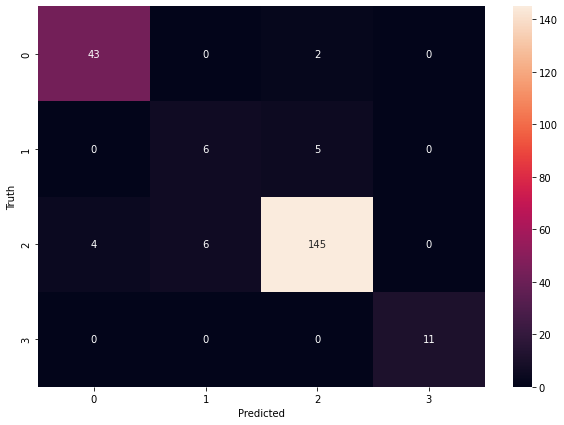

In [25]:
f1_score_svm = plot_results(model_svm, final_test, y_test)

In [26]:
from sklearn.ensemble import RandomForestClassifier

rs_2 = RandomizedSearchCV(RandomForestClassifier(), {
        'n_estimators': [1,5,10,15, 20, 25, 30,40,50,60,70,80,90,100,110,120,130,140,150,200,250,500],
    }, 
                          
    cv=5, 
    n_iter= 22,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100
)

rs_2.fit(final_train, y_train)

pd.DataFrame(rs_2.cv_results_)[['param_n_estimators','mean_test_score']]

Fitting 5 folds for each of 22 candidates, totalling 110 fits


,param_n_estimators,mean_test_score
0,1,0.911278
1,5,0.953383
2,10,0.950376
3,15,0.954887
4,20,0.951880
5,25,0.959398
6,30,0.956391
7,40,0.954887
8,50,0.956391
9,60,0.956391


In [27]:
print('Best Score : ' , rs_2.best_score_)
print('Best Parameters : ' ,rs_2.best_params_)

Best Score :  0.9593984962406015
Best Parameters :  {'n_estimators': 25}


In [28]:
model_rf = RandomForestClassifier(n_estimators=rs_2.best_params_.get('n_estimators'), random_state = SEED)

start_time_rf = time.time()
model_rf.fit(final_train, y_train)
elapsed_time_rf = time.time() - start_time_rf 

elapsed_time_rf

0.05585169792175293

In [29]:
model_rf.score(final_test, y_test)

0.963963963963964



Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.59      0.91      0.71        11
           2       0.99      0.95      0.97       155
           3       1.00      1.00      1.00        11

    accuracy                           0.96       222
   macro avg       0.90      0.97      0.92       222
weighted avg       0.97      0.96      0.97       222



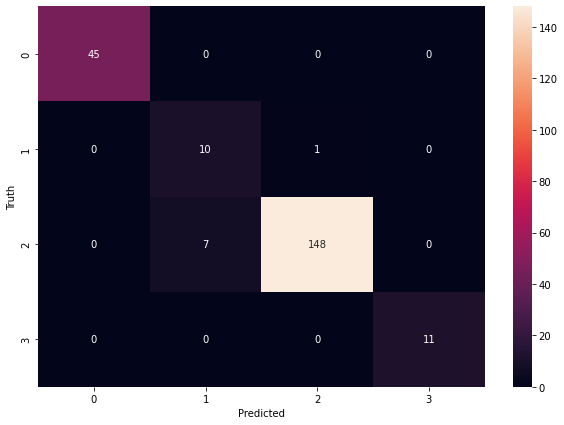

In [30]:
f1_score_rf =plot_results(model_rf, final_test, y_test)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

rs_3 = RandomizedSearchCV(KNeighborsClassifier(), {
        'n_neighbors': [5,10,15, 20, 25, 30,40,50,60,70,80,90,100,110,120,130,140,150],
        'weights' : ['uniform', 'distance']
    }, 
                          
    cv=5, 
    n_iter= 22,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_3.fit(final_train, y_train)

pd.DataFrame(rs_3.cv_results_)[['param_n_neighbors','param_weights', 'mean_test_score']]

Fitting 5 folds for each of 22 candidates, totalling 110 fits


,param_n_neighbors,param_weights,mean_test_score
0,130,uniform,0.727820
1,150,uniform,0.694737
2,120,uniform,0.742857
3,10,distance,0.950376
4,70,distance,0.950376
5,60,distance,0.948872
6,80,distance,0.950376
7,90,distance,0.950376
8,120,distance,0.951880
9,110,uniform,0.748872


In [32]:
print('Best Score : ' , rs_3.best_score_)
print('Best Parameters : ' ,rs_3.best_params_)

Best Score :  0.9518796992481203
Best Parameters :  {'weights': 'distance', 'n_neighbors': 120}


In [33]:
model_knn = KNeighborsClassifier(n_neighbors=rs_3.best_params_.get('n_neighbors'), weights= rs_3.best_params_.get('weights'))

start_time_knn = time.time()
model_knn.fit(final_train, y_train)
elapsed_time_knn = time.time() - start_time_knn 

elapsed_time_knn 

0.000997781753540039

In [34]:
model_knn.score(final_test, y_test)

0.954954954954955



Classification Report : 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        45
           1       0.59      0.91      0.71        11
           2       0.99      0.94      0.97       155
           3       1.00      1.00      1.00        11

    accuracy                           0.95       222
   macro avg       0.88      0.96      0.91       222
weighted avg       0.97      0.95      0.96       222



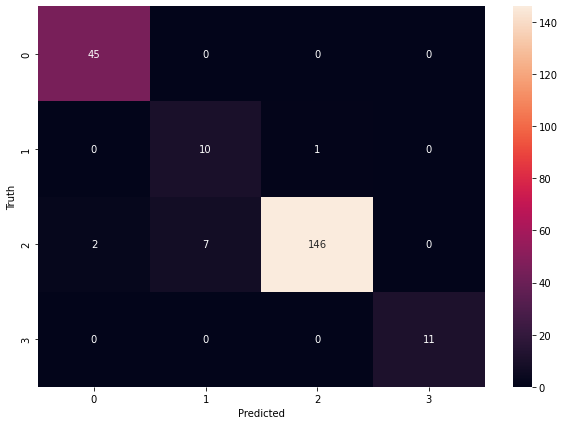

In [35]:
f1_score_knn = plot_results(model_knn, final_test, y_test)

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

rs_4 = RandomizedSearchCV(GradientBoostingClassifier(), {
        'n_estimators': [10, 20, 30,40,50,100,200,300,400,500],
        'learning_rate' : [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
    }, 
                          
    cv=5, 
    n_iter= 22,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_4.fit(final_train, y_train)

pd.DataFrame(rs_4.cv_results_)[['param_n_estimators','param_learning_rate','mean_test_score']]

Fitting 5 folds for each of 22 candidates, totalling 110 fits


,param_n_estimators,param_learning_rate,mean_test_score
0,100,1,0.954887
1,200,0.1,0.960902
2,200,1,0.956391
3,50,0.75,0.960902
4,300,0.1,0.959398
5,10,1,0.954887
6,500,0.5,0.960902
7,200,0.25,0.960902
8,400,0.5,0.962406
9,20,0.25,0.957895


In [37]:
print('Best Score : ' , rs_4.best_score_)
print('Best Parameters : ' ,rs_4.best_params_)

Best Score :  0.9624060150375939
Best Parameters :  {'n_estimators': 400, 'learning_rate': 0.5}


In [38]:
model_gbc = GradientBoostingClassifier(n_estimators = rs_4.best_params_.get('n_estimators'), learning_rate = rs_4.best_params_.get('learning_rate'), random_state = SEED)

start_time_gbc = time.time()
model_gbc.fit(final_train, y_train)
elapsed_time_gbc = time.time() - start_time_gbc 
elapsed_time_gbc

7.5018274784088135

In [39]:
model_gbc.score(final_test, y_test)

0.963963963963964



Classification Report : 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        45
           1       0.67      0.91      0.77        11
           2       0.99      0.95      0.97       155
           3       1.00      1.00      1.00        11

    accuracy                           0.96       222
   macro avg       0.90      0.97      0.93       222
weighted avg       0.97      0.96      0.97       222



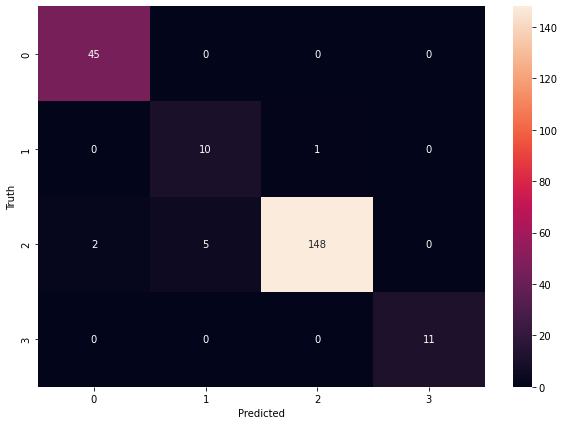

In [40]:
f1_score_gbc = plot_results(model_gbc, final_test, y_test)

In [41]:
from xgboost import XGBClassifier

rs_5 = RandomizedSearchCV(XGBClassifier(eval_metric = 'mlogloss', num_class = 4), {
        'objective' : ['multi:softmax','multi:softprob'],
        'n_estimators': [10, 20, 30,40,50,100,200],
        'learning_rate' : [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
    }, 
    cv=5, 
    n_iter= 30,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_5.fit(final_train, y_train)

pd.DataFrame(rs_5.cv_results_)[['param_n_estimators','param_learning_rate','param_objective','mean_test_score']]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,param_n_estimators,param_learning_rate,param_objective,mean_test_score
0,40,1,multi:softprob,0.951880
1,200,0.75,multi:softmax,0.951880
2,20,0.1,multi:softprob,0.951880
3,200,0.075,multi:softprob,0.951880
4,40,0.75,multi:softprob,0.953383
5,20,0.075,multi:softprob,0.944361
6,200,1,multi:softprob,0.957895
7,100,0.75,multi:softmax,0.953383
8,100,0.5,multi:softprob,0.953383
9,40,0.5,multi:softmax,0.951880


In [42]:
print('Best Score : ' , rs_5.best_score_)
print('Best Parameters : ' ,rs_5.best_params_)

Best Score :  0.9578947368421054
Best Parameters :  {'objective': 'multi:softprob', 'n_estimators': 200, 'learning_rate': 1}


In [43]:
model_xgbc = XGBClassifier(n_estimators = rs_5.best_params_.get('n_estimators'), learning_rate = rs_5.best_params_.get('learning_rate'), objective = rs_5.best_params_.get('objective'), eval_metric = 'mlogloss', random_state = SEED,  num_class = 4)

start_time_xgbc = time.time()
model_xgbc.fit(final_train, y_train)
elapsed_time_xgbc = time.time() - start_time_xgbc 
elapsed_time_xgbc

0.7086100578308105

In [44]:
model_xgbc.score(final_test, y_test)

0.9594594594594594



Classification Report : 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        45
           1       0.62      0.91      0.74        11
           2       0.99      0.95      0.97       155
           3       1.00      1.00      1.00        11

    accuracy                           0.96       222
   macro avg       0.89      0.96      0.92       222
weighted avg       0.97      0.96      0.96       222



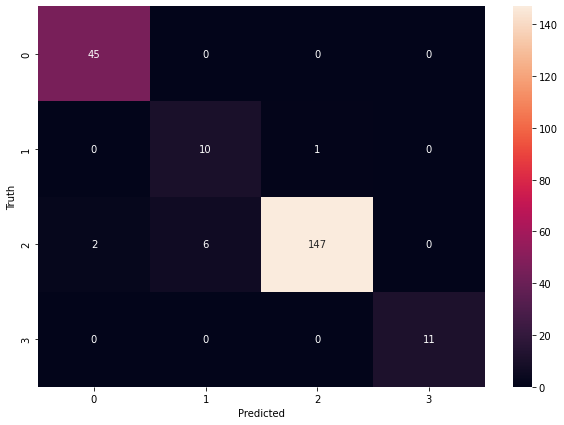

In [45]:
f1_score_xgbc =plot_results(model_xgbc, final_test, y_test)

In [46]:
from lightgbm import LGBMClassifier

rs_6 = RandomizedSearchCV(LGBMClassifier(objective = 'multiclass',  num_classes = 4), {
        'n_estimators': [10, 20, 30,40,50,100,200],
        'learning_rate' : [0.05, 0.075, 0.025, 0.001, 0.1, 0.25, 0.5, 0.75, 1]
    }, 
    cv=5, 
    n_iter= 30,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_6.fit(final_train, y_train)

pd.DataFrame(rs_6.cv_results_)[['param_n_estimators','param_learning_rate','mean_test_score']]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,param_n_estimators,param_learning_rate,mean_test_score
0,40,0.001,0.685714
1,50,0.25,0.953383
2,30,0.75,0.900752
3,200,0.001,0.685714
4,100,1,0.645113
5,30,0.05,0.939850
6,10,0.001,0.685714
7,10,0.5,0.950376
8,200,0.25,0.954887
9,30,0.5,0.950376


In [47]:
print('Best Score : ' , rs_6.best_score_)
print('Best Parameters : ' ,rs_6.best_params_)

Best Score :  0.9548872180451129
Best Parameters :  {'n_estimators': 100, 'learning_rate': 0.5}


In [48]:
model_lgbm = LGBMClassifier(n_estimators=rs_6.best_params_.get('n_estimators'),
                      random_state=SEED, objective = 'multiclass',learning_rate = rs_6.best_params_.get('learning_rate'),  num_classes = 4)

In [49]:
start_time_lgbm = time.time()
model_lgbm.fit(final_train, y_train)
elapsed_time_lgbm = time.time() - start_time_lgbm
elapsed_time_lgbm

0.11668753623962402

In [50]:
model_lgbm.score(final_test, y_test)

0.9594594594594594



Classification Report : 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        45
           1       0.62      0.91      0.74        11
           2       0.99      0.95      0.97       155
           3       1.00      1.00      1.00        11

    accuracy                           0.96       222
   macro avg       0.89      0.96      0.92       222
weighted avg       0.97      0.96      0.96       222



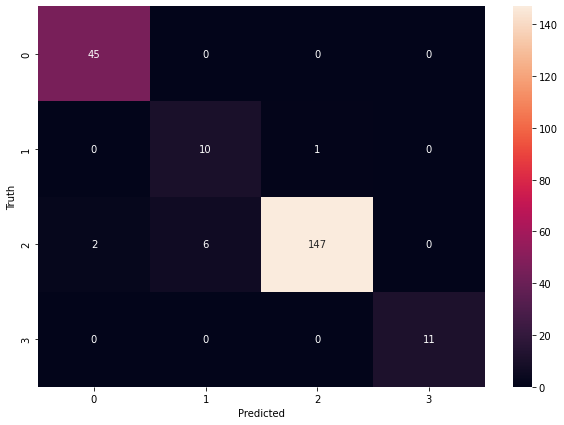

In [51]:
f1_score_lgbm = plot_results(model_lgbm, final_test, y_test)

In [52]:
accuracies = {'SVM' : model_svm.score(final_test, y_test),
                 'kNN': model_knn.score(final_test, y_test),
                 'RF' : model_rf.score(final_test, y_test),
                 'gbm': model_gbc.score(final_test, y_test),
                 'xgbm': model_xgbc.score(final_test, y_test),
                 'lgbm' : model_lgbm.score(final_test, y_test)}

models = list(accuracies.keys())
acc = list(accuracies.values())

In [53]:
training_times = {'SVM' : elapsed_time_svm,
                 'kNN': elapsed_time_knn,
                 'RF' : elapsed_time_rf,
                 'gbm': elapsed_time_gbc,
                 'xgbm': elapsed_time_xgbc,
                 'lgbm' : elapsed_time_lgbm}

models = list(training_times.keys())
t_times = list(training_times.values())

In [54]:
f1_scores = {'SVM' : f1_score_svm,
                 'kNN': f1_score_knn,
                 'RF' : f1_score_rf,
                 'gbm': f1_score_gbc,
                 'xgbm': f1_score_xgbc,
                 'lgbm' : f1_score_lgbm}

models = list(f1_scores.keys())
scores = list(f1_scores.values())

In [55]:
# # saving F1 scores, accuracy and training time dictionaries in CSV files

# df_training_time = pd.DataFrame.from_dict([training_times]) 
# df_training_time.to_csv (r'Training_time_seed_{}.csv'.format(SEED), header=True, index=[SEED])

# df_accuracy = pd.DataFrame.from_dict([accuracies]) 
# df_accuracy.to_csv (r'Accuracy_seed_{}.csv'.format(SEED),  header=True, index=[SEED])

# df_f1_score = pd.DataFrame.from_dict([f1_scores]) 
# df_f1_score.to_csv (r'f1_score_seed_{}.csv'.format(SEED),  header=True, index=[SEED])


#### Plotting results for 20 seeds

#### Service 1

In [56]:
df_accuracies_s1 = pd.read_csv('S1_FL_Accuracy.csv').mean(axis=0)
df_F1_scores_s1 = pd.read_csv('S1_FL_F1.csv').mean(axis=0)
df_training_times_s1 = pd.read_csv('S1_FL_TT.csv').mean(axis=0)

#### Service 2

In [57]:
df_accuracies_s2 = pd.read_csv('S2_FL_Accuracy.csv').mean(axis=0)
df_F1_scores_s2 = pd.read_csv('S2_FL_F1.csv').mean(axis=0)
df_training_times_s2 = pd.read_csv('S2_FL_TT.csv').mean(axis=0)

#### For Grouped Bar Plots

In [58]:
models_ml = df_F1_scores_s1.keys()
f1_Scores_service_1 = df_F1_scores_s1.values
f1_Scores_service_2 = df_F1_scores_s2.values

training_times_service_1 = df_training_times_s1.values
training_times_service_2 = df_training_times_s2.values

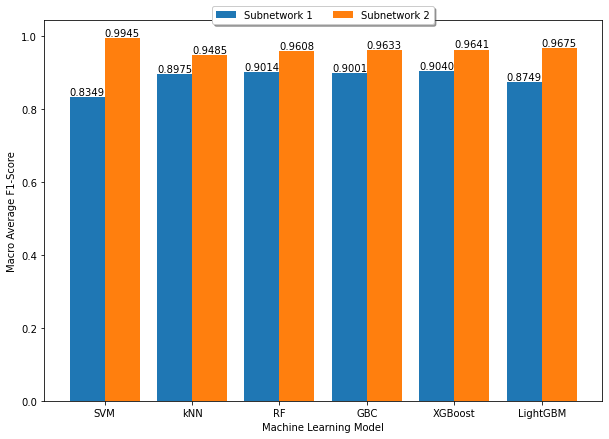

In [59]:
fig, ax = plt.subplots(figsize=(10,7))

# Multi bar Chart
x_axis = np.arange(len(models_ml))
p1 = ax.bar(x_axis -0.2, f1_Scores_service_1, width=0.4, label = 'Subnetwork 1')
p2 = plt.bar(x_axis +0.2, f1_Scores_service_2, width=0.4, label = 'Subnetwork 2')

for c in ax.containers: ax.bar_label(c, fmt='%.4f')
    
plt.xticks(x_axis, models_ml)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

# Display
plt.ylabel('Macro Average F1-Score')
plt.xlabel('Machine Learning Model')
plt.show()

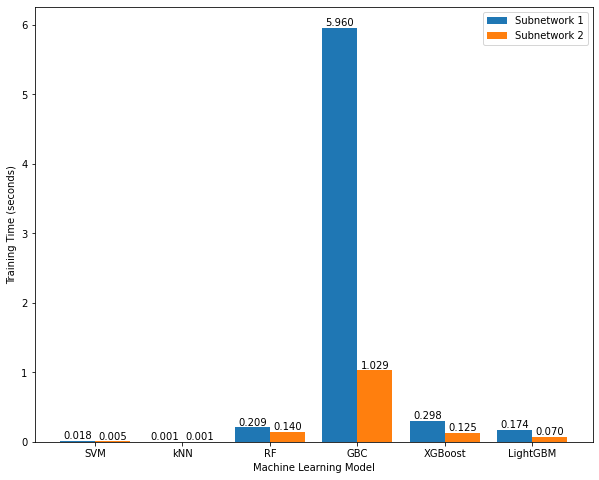

In [60]:
fig, ax = plt.subplots(figsize=(10,8))

# Multi bar Chart
x_axis = np.arange(len(models_ml))

p1 = ax.bar(x_axis -0.2, training_times_service_1, width=0.4, label = 'Subnetwork 1')
   
p2 = plt.bar(x_axis +0.2, training_times_service_2, width=0.4, label = 'Subnetwork 2')

for c in ax.containers: ax.bar_label(c, fmt='%.3f')

plt.xticks(x_axis, models_ml)

# Add legend

plt.legend()

# Display
plt.ylabel('Training Time (seconds)')
plt.xlabel('Machine Learning Model')
plt.show()